# **PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle**

## Постановка задачи

**Проблема:** 

Представим, что мы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

**Цель проекта:** построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

**Задачи проекта:**

* ознакомиться с входными данными
* изучить пример машинного обучения
* выполнить подготовку данных, которые будут использованы для обучения модели
* проверить эффективность предлагаемой модели, используя метрику MAPE
* принять участие в соревнованиях на площадке kaggle.com

## Знакомимся с данными

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

## Импорт библиотек

In [140]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import geopy.distance
import re
from collections import Counter
import category_encoders as ce

# для удобства просмотра
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

# инструменты для лингвистического анализа:
import string
import spacy  
import nltk  
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer  
nltk.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from wordcloud import WordCloud  # Небольшой генератор облаков слов на Python.

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split # Загружаем специальный удобный инструмент для разделения датасета
from sklearn.preprocessing import MinMaxScaler # инструмент для масштабирования каждой функции до заданного диапазона
from sklearn.feature_selection import f_classif
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [ ]:
df_train.info()

In [9]:
df_train.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144


In [ ]:
df_test.info()

In [10]:
df_test.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171


In [11]:
sample_submission.head(1)

,reviewer_score,id
0,1,488440


In [ ]:
sample_submission.info()

In [12]:
# ВАЖНО! Для корректной обработки признаков объединяем трейн и тест в один датасет.
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['reviewer_score'] = 0 

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
hotels_isnull = hotels.isnull().sum()
print(
    f'\nСтолбцы с пропусками данных:\n{hotels_isnull[hotels_isnull > 0]}'
)


Столбцы с пропусками данных:
lat    3268
lng    3268
dtype: int64


# 1. Исследование и проектирование признаков (FEATURE ENGINEERING):

## Признак hotel_name — название отеля

Преобразованный признак 'hotel_name' в дальнейшем используем для определения расстояния от отеля до центра города.

In [14]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = hotels['hotel_name'].isin(name_rep)
addresses_rep = hotels[mask][['hotel_name', 'hotel_address']].value_counts()

print('Одинаковые Названия отелей с разными адресами:')
display(addresses_rep)

# чтобы различать эти отели при анализе - добавим в название город:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print('Проверим полученные изменения:')
mask = hotels['hotel_name'].str.contains(name_rep[0])
display(hotels[mask]['hotel_name'].value_counts())

Одинаковые Названия отелей с разными адресами:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

Проверим полученные изменения:


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

## Признак hotel_address - адрес отеля

Почтовые индексы:

* http://ruqrz.com/pochtovye-indeksy-londona/ - Англия
* https://ru.youbianku.com/%D0%9D%D0%B8%D0%B4%D0%B5%D1%80%D0%BB%D0%B0%D0%BD%D0%B4%D1%8B - Нидерланды
* https://ru.youbianku.com/%D0%90%D0%B2%D1%81%D1%82%D1%80%D0%B8%D1%8F - Австрия
* https://ru.youbianku.com/%D0%98%D1%82%D0%B0%D0%BB%D0%B8%D1%8F - Италия
* https://ru.youbianku.com/%D0%98%D1%81%D0%BF%D0%B0%D0%BD%D0%B8%D1%8F - Испания
* https://ru.youbianku.com/%D0%A4%D1%80%D0%B0%D0%BD%D1%86%D0%B8%D1%8F - Франция

In [15]:
# Рассмотрим структуру строк с данными адреса
addresses = pd.Series(hotels['hotel_address'].unique())
addresses

0                                       Via Senigallia 6 20161 Milan Italy
1                    Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
2                              Mallorca 251 Eixample 08008 Barcelona Spain
3             Piazza Della Repubblica 17 Central Station 20124 Milan Italy
4       Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
                                       ...                                
1488        45 Park Lane Westminster Borough London W1K 1PN United Kingdom
1489                          6 Avenue Fr miet 16th arr 75016 Paris France
1490                     22 avenue de Villiers 17th arr 75017 Paris France
1491                        17 rue de Richelieu 1st arr 75001 Paris France
1492                          64 Rue Crozatier 12th arr 75012 Paris France
Length: 1493, dtype: object

Создадим новый признак 'hotel_country', что бы потом сопоставить с национальностью рецензента

In [16]:
# Из адреса отеля выделяем страну
countries = addresses.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])

# Из адреса отеля выделяем город
cities = addresses.apply(lambda x: x.split()[-5] if x.endswith('United Kingdom') else x.split()[-2])

addresses = pd.DataFrame(
    {'address': addresses, 'country': countries, 'city': cities})

print('В каждой стране отели представлены только из одного города:')
display(addresses.groupby(['country', 'city']).count())
 
# Добавляем в данные ноывй признак - страну
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])

# Кодируем информацию о стране методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_country']) 
type_bin = encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)

В каждой стране отели представлены только из одного города:


,,address
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


Создадим новый признак 'hotel_postcode', что бы потом использовать его для заполнения недостающих координат

In [17]:
def get_postcode(address):
    """Извлечение почтового индекса из строки с адресом."""
    address_list = address.split()
    postcode_place = {
        'Kingdom': -4, 
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    postcode = str(address_list[postcode_place[address_list[-1]]])
    
    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode
   
# Добавляем в данные ноывй признак - почтовый индекс 
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

## Признаки lat и lng - географические координаты отеля

С помощью данных признаков создадим новый признак 'hotel_distance_to_center' - расстояние до центра города.

Для формирования данного признака нужны координаты центра каждого города. Их берем с сайта: https://dateandtime.info/

In [18]:
# Сначала заполним пропуски в признаках lat и lng
without_coor = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts())
print(f'Количество отелей с отсутствующими координатами: {without_coor}')

# Вычисляем средние значения координат для каждого района с одинаковым почтовым индексом:
pivot_coor = pd.pivot_table(
    hotels, 
    index='hotel_postcode', 
    values=['lat', 'lng'], 
    dropna=True,                   
    aggfunc='mean')

# Заполняем пропуски
hotels['lat'] = hotels.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] \
    if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] \
    if np.isnan(row['lng']) else row['lng'], axis=1)

Количество отелей с отсутствующими координатами: 17


In [19]:
# Данные с координатами центров гордов
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')


def get_dist_to_center(country, lng, lat):
    """Вычисление дистанции до центра города по координатам."""
    center_lat = centers['center_lat'][country]  
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km


"""
Можно вычислять координаты одной строкой кода, при помощи lambda.
Но geopy.distance.geodesic функция довольно медленная.
Чтобы не обрабатывать 500 тыс. строк - посчитаем эту характеристику 
для каждого отеля и сопоставим полученные результаты.

"""
# Удаляем повторяющиеся названия отелей.
hotels_unique = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)
hotels = hotels.merge(hotels_unique, how='left', on='hotel_name', sort=False)

print('Проверим новый признак:')
hotels[['hotel_name', 'hotel_distance_to_center']]

# теперь столбцы с координатами можно удалить:
hotels.drop(['lng', 'lat'], axis=1, inplace=True) 

Проверим новый признак:


## Признак review_date — дата, когда рецензент разместил соответствующий отзыв

In [20]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# извлекаем месяц из даты
hotels['review_month'] = hotels['review_date'].dt.month
# извлекаем день недели из даты
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek

display(hotels['review_month'].value_counts())

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: review_month, dtype: int64

Визуализируем влияние месяца посещения отеля на средние оценки

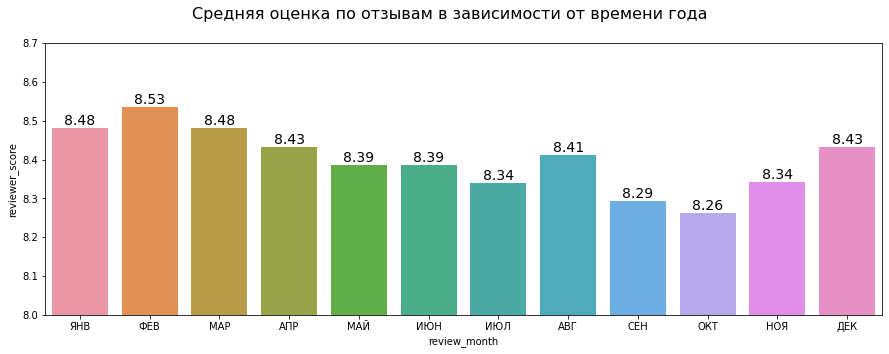

In [21]:
mask = hotels['sample'] == 1
pivot_month = hotels[mask][['review_month', 'reviewer_score']].groupby(
    'review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score'])
ax5.set_xticklabels([
    'ЯНВ', 'ФЕВ', 'МАР', 'АПР', 'MAЙ', 'ИЮН', 
    'ИЮЛ', 'АВГ', 'СЕН', 'ОКТ', 'НОЯ', 'ДЕК'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

Визуализируем влияние дня недели посещения отеля на средние оценки

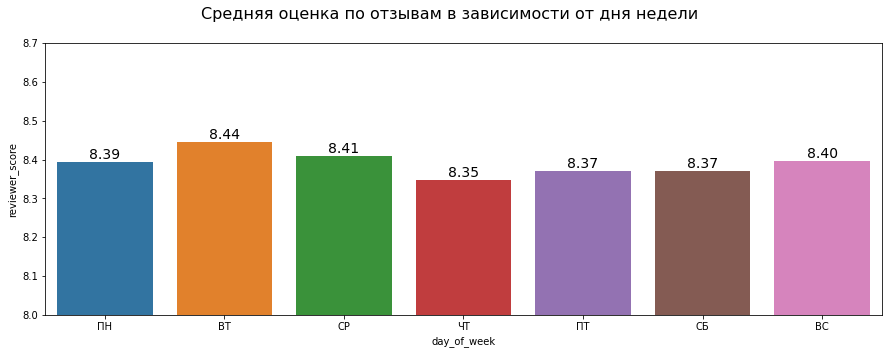

In [22]:
mask = hotels['sample'] == 1
pivot_day = hotels[mask][['day_of_week', 'reviewer_score']].groupby(
    'day_of_week').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от дня недели', size=16)
bar_month = sns.barplot(
    x=pivot_day.index, 
    y=pivot_day['reviewer_score'])
ax5.set_xticklabels([
    'ПН', 'ВТ', 'СР', 'ЧТ', 'ПТ', 'СБ', 'ВС'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

In [23]:
# Кодируем признак в высокий или низкий сезон состоялось посещение отеля
# Выбраны первые четыре месяца в рейтинге в сторке кода выше [8,7,5,10]. Не очевидно, но показало лучший результат. 
hotels['high_season'] = hotels['review_month'].apply(lambda x: 1 if x in [8,7,5,10] else 0)

In [24]:
# кодировка дня недели методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['day_of_week']) 
type_bin = encoder.fit_transform(hotels['day_of_week'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [25]:
# кодировка месяца методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['review_month']) 
type_bin = encoder.fit_transform(hotels['review_month'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [26]:
# удаляем признак даты отзыва
hotels.drop(['review_date','review_month', 'day_of_week'],axis=1,inplace=True)

## Признак reviewer_nationality — страна рецензента

In [27]:
# проанализируем, например, 30 самых распространенных стран, 
# из которых приезжают туристы и выделим общие группы:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
nationality_count = hotels["reviewer_nationality"].value_counts()[:30]
nationality_count

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
India                         3437
Greece                        3406
China                         3400
Sweden                        3368
New Zealand                   3237
Singapore                     3091
Hong Kong                     3013
Poland                        2891
Qatar               

In [28]:
# Выделим основные англоязычные страны:
english_list = ['United Kingdom', 
                'United States of America', 
                'Australia',
                'Ireland', 
                'Canada', 
                'New Zealand']
hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in english_list else 0)

# Выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar']
hotels['reviewer_n_est'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in muslim_list else 0)

# Добавим признак резидентства туриста по отношению к стране, в которой находится отель:
hotels['reviewer_resident'] = hotels.apply(
    lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

Визуализируем соотношение средних значений целевой переменной в разрезе полученных признаков:

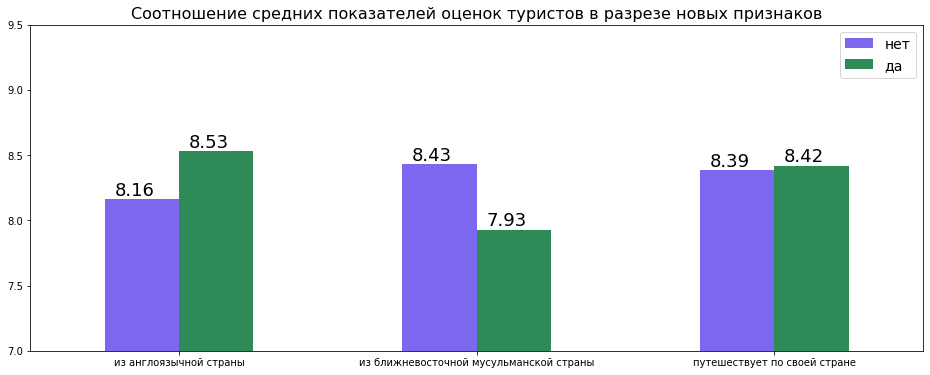

In [29]:
# подготовим данные для диаграммы:
mask = hotels['sample'] == 1
pivot_en = hotels[mask].groupby('reviewer_en')['reviewer_score'].mean()
pivot_n_est = hotels[mask].groupby('reviewer_n_est')['reviewer_score'].mean()
pivot_resident = hotels[mask].groupby('reviewer_resident')['reviewer_score'].mean()

pivot = pd.DataFrame({
    'из англоязычной страны': pivot_en,
    'из ближневосточной мусульманской страны': pivot_n_est,
    'путешествует по своей стране': pivot_resident 
}).T

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    ax=ax2, 
    kind='bar', 
    color=['mediumslateblue', 'seagreen'], 
    rot=0)
ax2.set_title(
    'Соотношение средних показателей оценок туристов в разрезе новых признаков', size=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)

# для наглядности добавим на диаграмму подписи данных:
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=18)

plt.ylim(7, 9.5);

In [30]:
# Кодируется признак национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
data = pd.concat([hotels, type_bin], axis=1)

## Признаки - Количество слов в отрицательных и положительных отзывах

Целевая переменная демонстрирует зависимость от обеих величин. Соединим оба эффекта в один, добавив разницу количества слов в позитивной и негативной частях отзыва (предварительно нормализуем обе шкалы):

In [31]:
mm_scaler = MinMaxScaler()

hotels['review_total_positive_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

hotels['review_total_negative_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# соединим эти показатели в один, отрицательные слова - с отрицательным коэффициентом:
hotels['review_total_word_counts_diff_norm'] = \
    hotels['review_total_positive_word_counts_norm'] - \
    hotels['review_total_negative_word_counts_norm']

# а также добавим флаг - преобладают ли позитивные слова над негативными 
# в размерностях соответствующих диапазонов:
hotels['positive_words_more'] = hotels['review_total_word_counts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0)

hotels.drop(
    ['review_total_positive_word_counts_norm', 
     'review_total_negative_word_counts_norm', 
     'review_total_word_counts_diff_norm'], 
    axis=1, inplace=True)

Также добавим долю одной из частей (второй показатель будет обратно пропорциональным, очевидно - не значимым):

In [32]:
hotels['review_total_word_counts'] = \
    hotels['review_total_positive_word_counts'] + \
    hotels['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными (по 0.5):
hotels['review_positive_word_proportion'] = hotels.apply(
    lambda row: 0.5 if row['review_total_word_counts'] == 0 \
            else row['review_total_positive_word_counts'] / row['review_total_word_counts'],
axis=1)

# удаляем вспомогательный столбец:
hotels.drop('review_total_word_counts', axis = 1, inplace=True)

## Признак total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом

In [33]:
print('Посмотрим на количество отзывов рецензентов по группам активности:')
print(hotels['total_number_of_reviews_reviewer_has_given'].groupby(
    pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], 
           np.arange(0, 360, 25))).agg('count'))

# логарифмируем значение признака, чтобы оставить только информацию 
# о степени (порядке) активности рецензента:
hotels['total_number_of_reviews_reviewer_has_given'] = \
    hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))

Посмотрим на количество отзывов рецензентов по группам активности:
total_number_of_reviews_reviewer_has_given
(0, 25]       488425
(25, 50]       21640
(50, 75]        3914
(75, 100]       1149
(100, 125]       294
(125, 150]       144
(150, 175]       119
(175, 200]        21
(200, 225]        12
(225, 250]         8
(250, 275]         2
(275, 300]         4
(300, 325]         4
(325, 350]         1
Name: total_number_of_reviews_reviewer_has_given, dtype: int64


## Признак tags — теги, которые рецензент дал отелю

Самые популярные тэги

In [34]:
from collections import Counter

hotels['tags_most'] = hotels['tags'].apply(lambda x: (x.replace('[', '').replace(']', '').replace("'", '').split(',')))

tags_list = []
for x in hotels['tags_most']:
    for tag in x:
        tag = tag.strip()
        tags_list.append(tag)
        
tags_count = Counter(tags_list)
tags_count.most_common(40)

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670),
 ('Twin Room', 8321),
 ('Stayed 7 nights', 7399),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6107),
 ('Superior Twin Room', 6064),
 ('Deluxe Double or Twin Room', 5998),
 ('Club Double Room', 5908),
 ('Qu

Рассмотрим и проанализируем типы тегов:

In [35]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))

print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}')

print('Примеры:')
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[0])
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[1])

Максимальное количество тегов в 1 строке данных: 6
Примеры:
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


**Можно выделить 6 типов тегов:**
* путешествие с домашними животными        
* путешествие по работе / отдых            
* путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа)                               
* категория номера 
* длительность поездки 
* доступ осуществляется с мобильного устройства 

In [36]:
"""
Принцип выделения полезных свойств следующий - мы знаем, что максимальное 
количество тегов 6 и знаем их возможные типы. Все они, кроме типа комнаты, 
укладываются в стандартный шаблон. Будем искать в каждой строке один из пяти
известных шаблонов тега и удалать из строки после обработки. Если останется 
какой-то еще тег - он и будет типом номера.
"""

# создаем новые признаки:
def get_tags(tags_string):
    """Выделение 6 типов тегов по шаблонам."""
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # сразу кодируем тип путешественника:
    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    # формируем новые параметры:
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 #  по умолчанию не считаем поездку командировкой
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    
    # распределяем те теги, которые есть в исходной строке:
    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)

        if teg == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(teg)

        if teg == 'Leisure trip':
            tags_list.remove(teg)

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', teg)][0]           
            tags_list.remove(teg)
            
        if len(tags_list) > 0:
            tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type
        
# формируем новые признаки:
hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index)

print('Количество уникальных значений в новых признаках:')
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()

Количество уникальных значений в новых признаках:


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       32
tag_room_type        2394
dtype: int64

Рассмотрим категории номеров. Выделим их в группы. Возможно, в зависимости от номера будут оличатся отзывы.

    Из типа номера дополнительно выделим признак - номер с видом (возможно, что средний балл отзывов гостей таких номеров должен быть выше обычных).

In [37]:
# оптимизируем тип данных (для последующей диаграммы):
hotels['tag_count_nights'] = hotels['tag_count_nights'].astype('int8')

# добавим признак номера с видом:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(
    lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)


# сформируем список основных категорий отельных номеров 
# и присвоим соответствующее значение каждой группе:
def get_room_type(tag):
    """Классификация типа номера."""
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 
                  'Standard', 'Superior', 'Comfort', 'Club', 'Suite', 
                  'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


# группируем данные с типом номера:
hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

# кодируем новые признаки
encoder_t = ce.OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = ce.OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

***Зависимость средних оценок от категорий номера:***

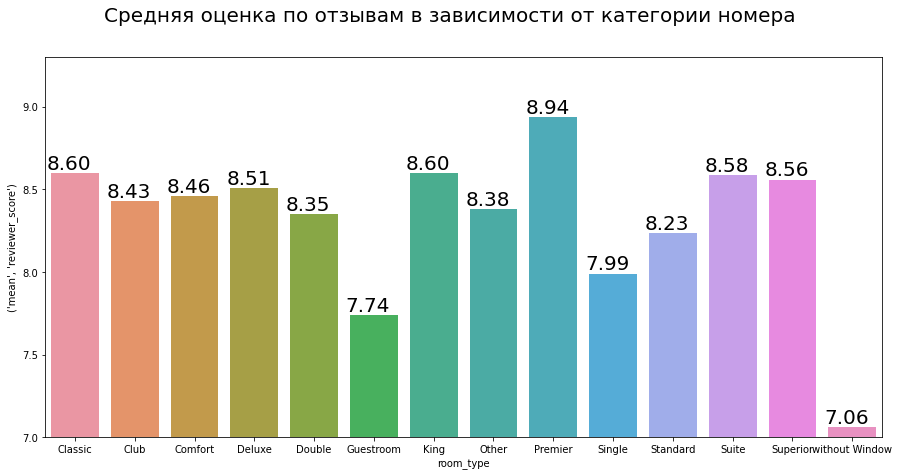

In [38]:
# визуализируем различия в оценках туристов, в зависимости от типа номера:
pivot_types = pd.pivot_table(hotels[hotels['sample'] == 1], 
                             index='room_type', 
                             values='reviewer_score', 
                             aggfunc=['count', 'mean'])

fig4, ax4 = plt.subplots(figsize=(15, 7))
plt.suptitle('Средняя оценка по отзывам в зависимости от категории номера', size=20)
bar_types = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

## Признаки: Отрицательный и Положительный отзывы

Для того чтобы параметрически оценить эти данны - нужен будет лингвистический анализ текста. 

### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER:

  SentimentIntensityAnalyzer от VADER выводит оценку на 3 уровнях классификации, а также составную оценку. В результате мы получим словарь нормализованных оценок тональности текста по категориям:
- негативная оценка
- нейтральная оценка
- позитивная

Визуализируем самые популярные слова

In [141]:
# сохраним в функцию способ визуализации слов:
def show_wordcloud(data, background_color, colormap):
    """Рисуем облако слов с заданными параметрами."""
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 30,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [142]:
# визуализируем основные слова положительных и отрицательных частей отзывов
# загружаем словарь для лемматизации
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def clean_text(text):
    """Очистка от стоп-слов и лемматизация текста"""
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


def get_words_string(words_data):
    """Соединение очищенных слов в единую строку"""
    words_string = ''
    for word in words_data:
        words_string = words_string + word + ' '
    return words_string


def draw_cloud(text_column, background, color_map):
    """Визуализация словарных наборов"""
    hotels['temp'] = hotels[text_column].apply(
        lambda x: x.replace('No Negative', '').replace('No Positive', ''))
    hotels.temp = hotels[text_column].apply(clean_text)
    cloud_data = hotels.temp.apply(get_words_string)
    # воспользуемся функцией для визуализации тегов:
    show_wordcloud(cloud_data, background, color_map)


ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:



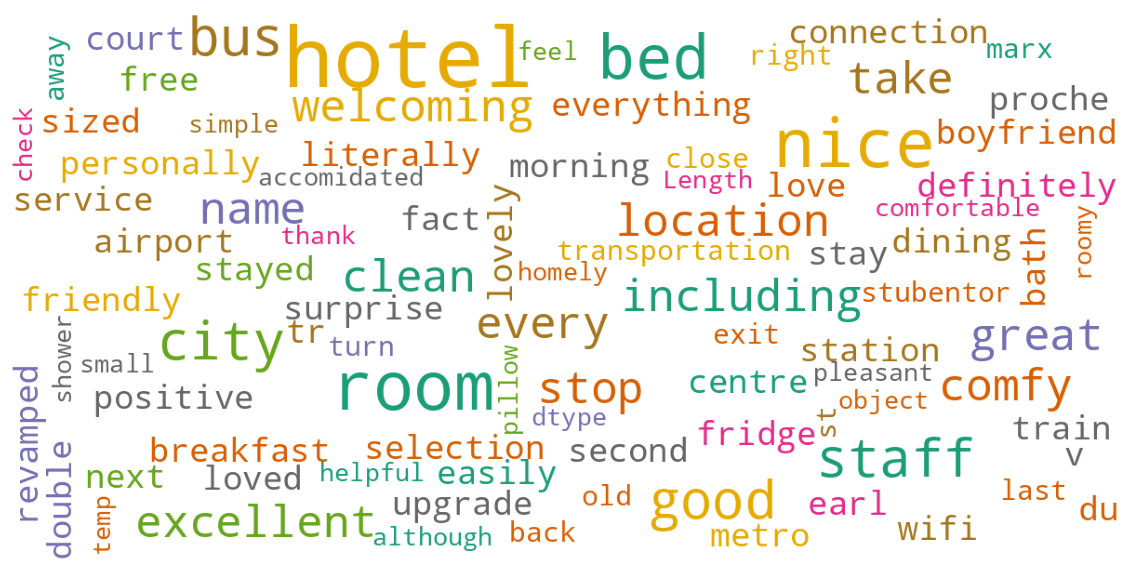

In [143]:
print('\nОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('positive_review', 'white', 'Dark2');

ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:


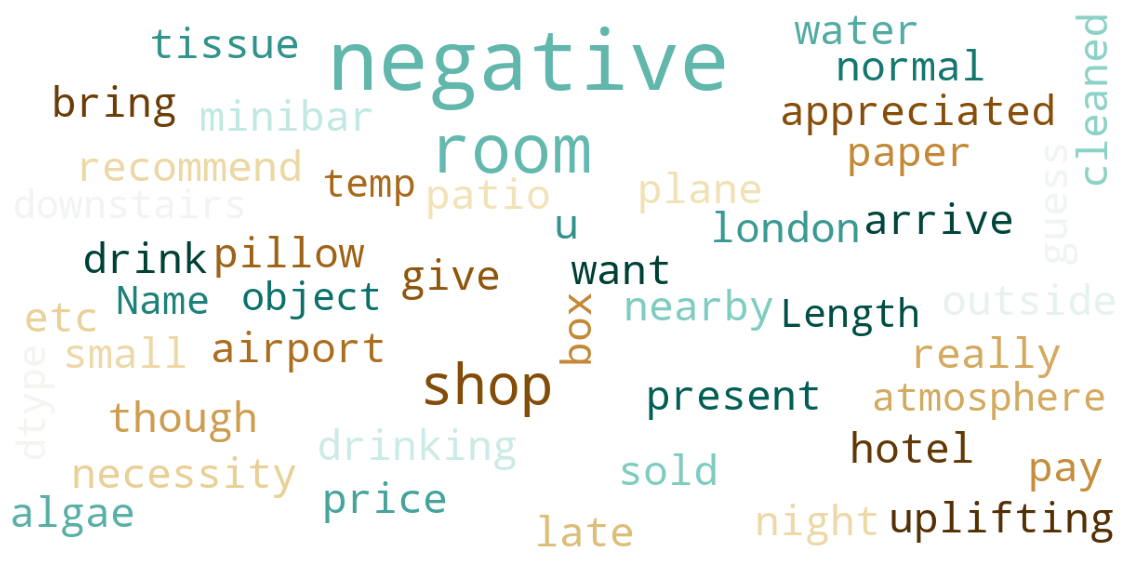

In [144]:
print('ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:')
draw_cloud('negative_review', 'white', 'BrBG');

In [127]:
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(sia_neg.polarity_scores(example), '\n')

# добавим контекст:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного контекста):')
print(sia_neg.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(sia_pos.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [128]:
%%time
hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])

CPU times: user 4min 42s, sys: 3.1 s, total: 4min 45s
Wall time: 4min 46s


# 2. Отбор признаков

In [129]:
# создаем дубликат базы для дальнейших манипуляций со столбцами (для обратимости экспериментов):
hotels_copy = hotels.copy()

In [130]:
print(f'Текущее получившееся количество признаков: {len(hotels_copy.columns)}')
print('(включая целевой столбец и метку тест/трейн)')

# удалим нечисловые данные:
object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | \
                      (hotels[s].dtype.name == 'category') | \
                      (hotels[s].dtypes == 'datetime64[ns]'))]

print(f'Удалим {len(object_columns)} столбцов с нечисловыми данными')
hotels_copy = hotels_copy.drop(object_columns, axis = 1)

Текущее получившееся количество признаков: 91
(включая целевой столбец и метку тест/трейн)
Удалим 16 столбцов с нечисловыми данными


In [131]:
hotels_copy.shape

(515738, 75)

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ

In [146]:
corr = hotels_copy.corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.8
mask_2 = np.abs(corr) <= -0.8

corr_data = corr[mask_1 | mask_2]

# проверка признака на мультиколлинеарность
# plt.rcParams['figure.figsize'] = (55,55)
# sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')

In [132]:
# Удаляем признаки с высокой кореляцией:
hotels_copy.drop(['additional_number_of_scoring'], axis = 1, inplace=True)

In [133]:
hotels_copy.shape

(515738, 74)

### ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Воспользуемся для оценки дисперсионным анализом ANOVA.

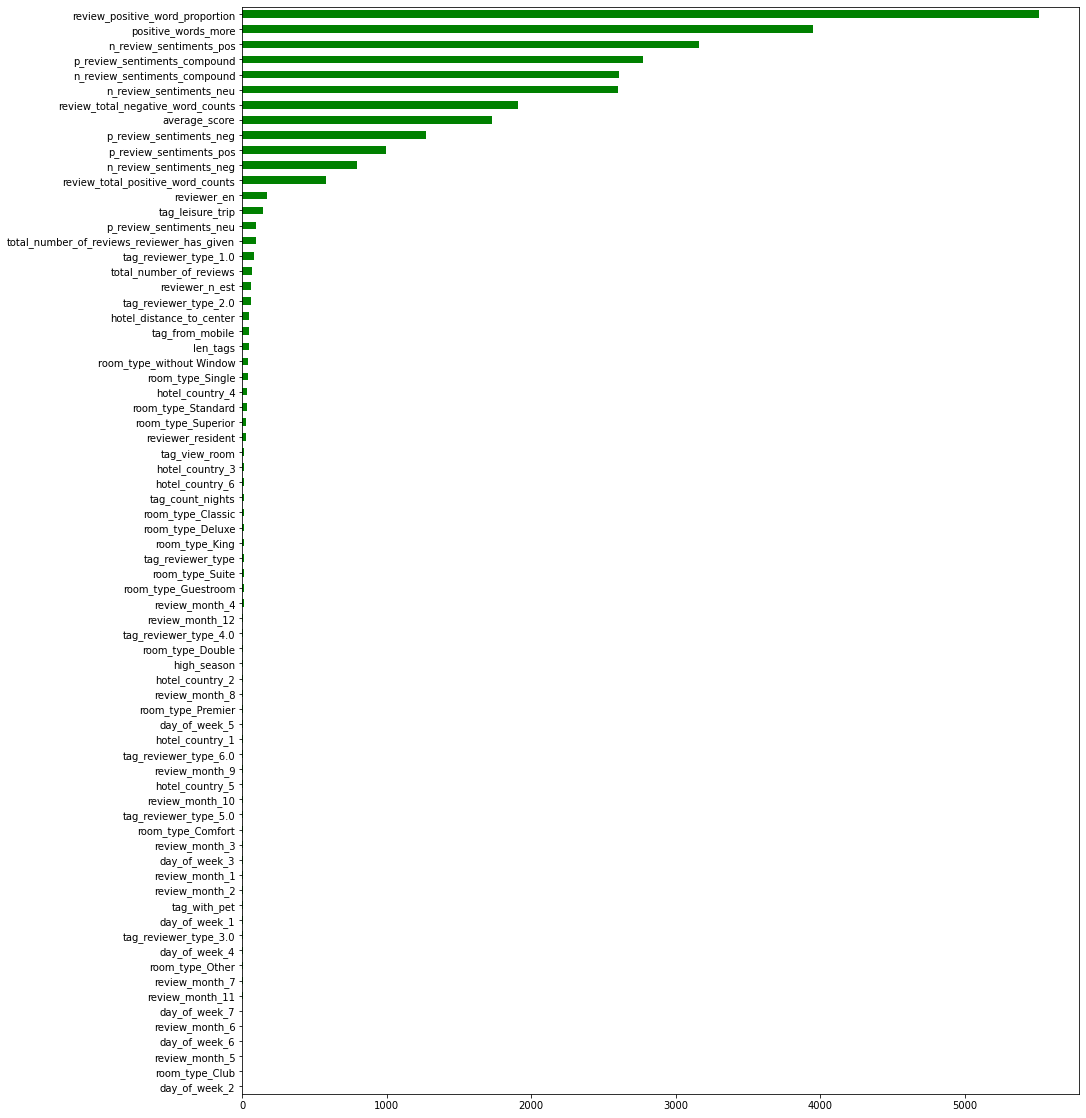

In [134]:
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

Удаление признаков ухудшает score.

# 3. Обучение модели и получение предсказания (Model Building):

In [135]:
# Теперь выделим тестовую часть
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

In [136]:
y = train_data.reviewer_score.values            
X = train_data.drop(['reviewer_score'], axis=1)

In [137]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [138]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 73), (386803, 73), (386803, 72), (309442, 72), (77361, 72))

In [139]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [145]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [147]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred), 4))

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 4))

# print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8508
MAPE: 12.0856


<AxesSubplot:>

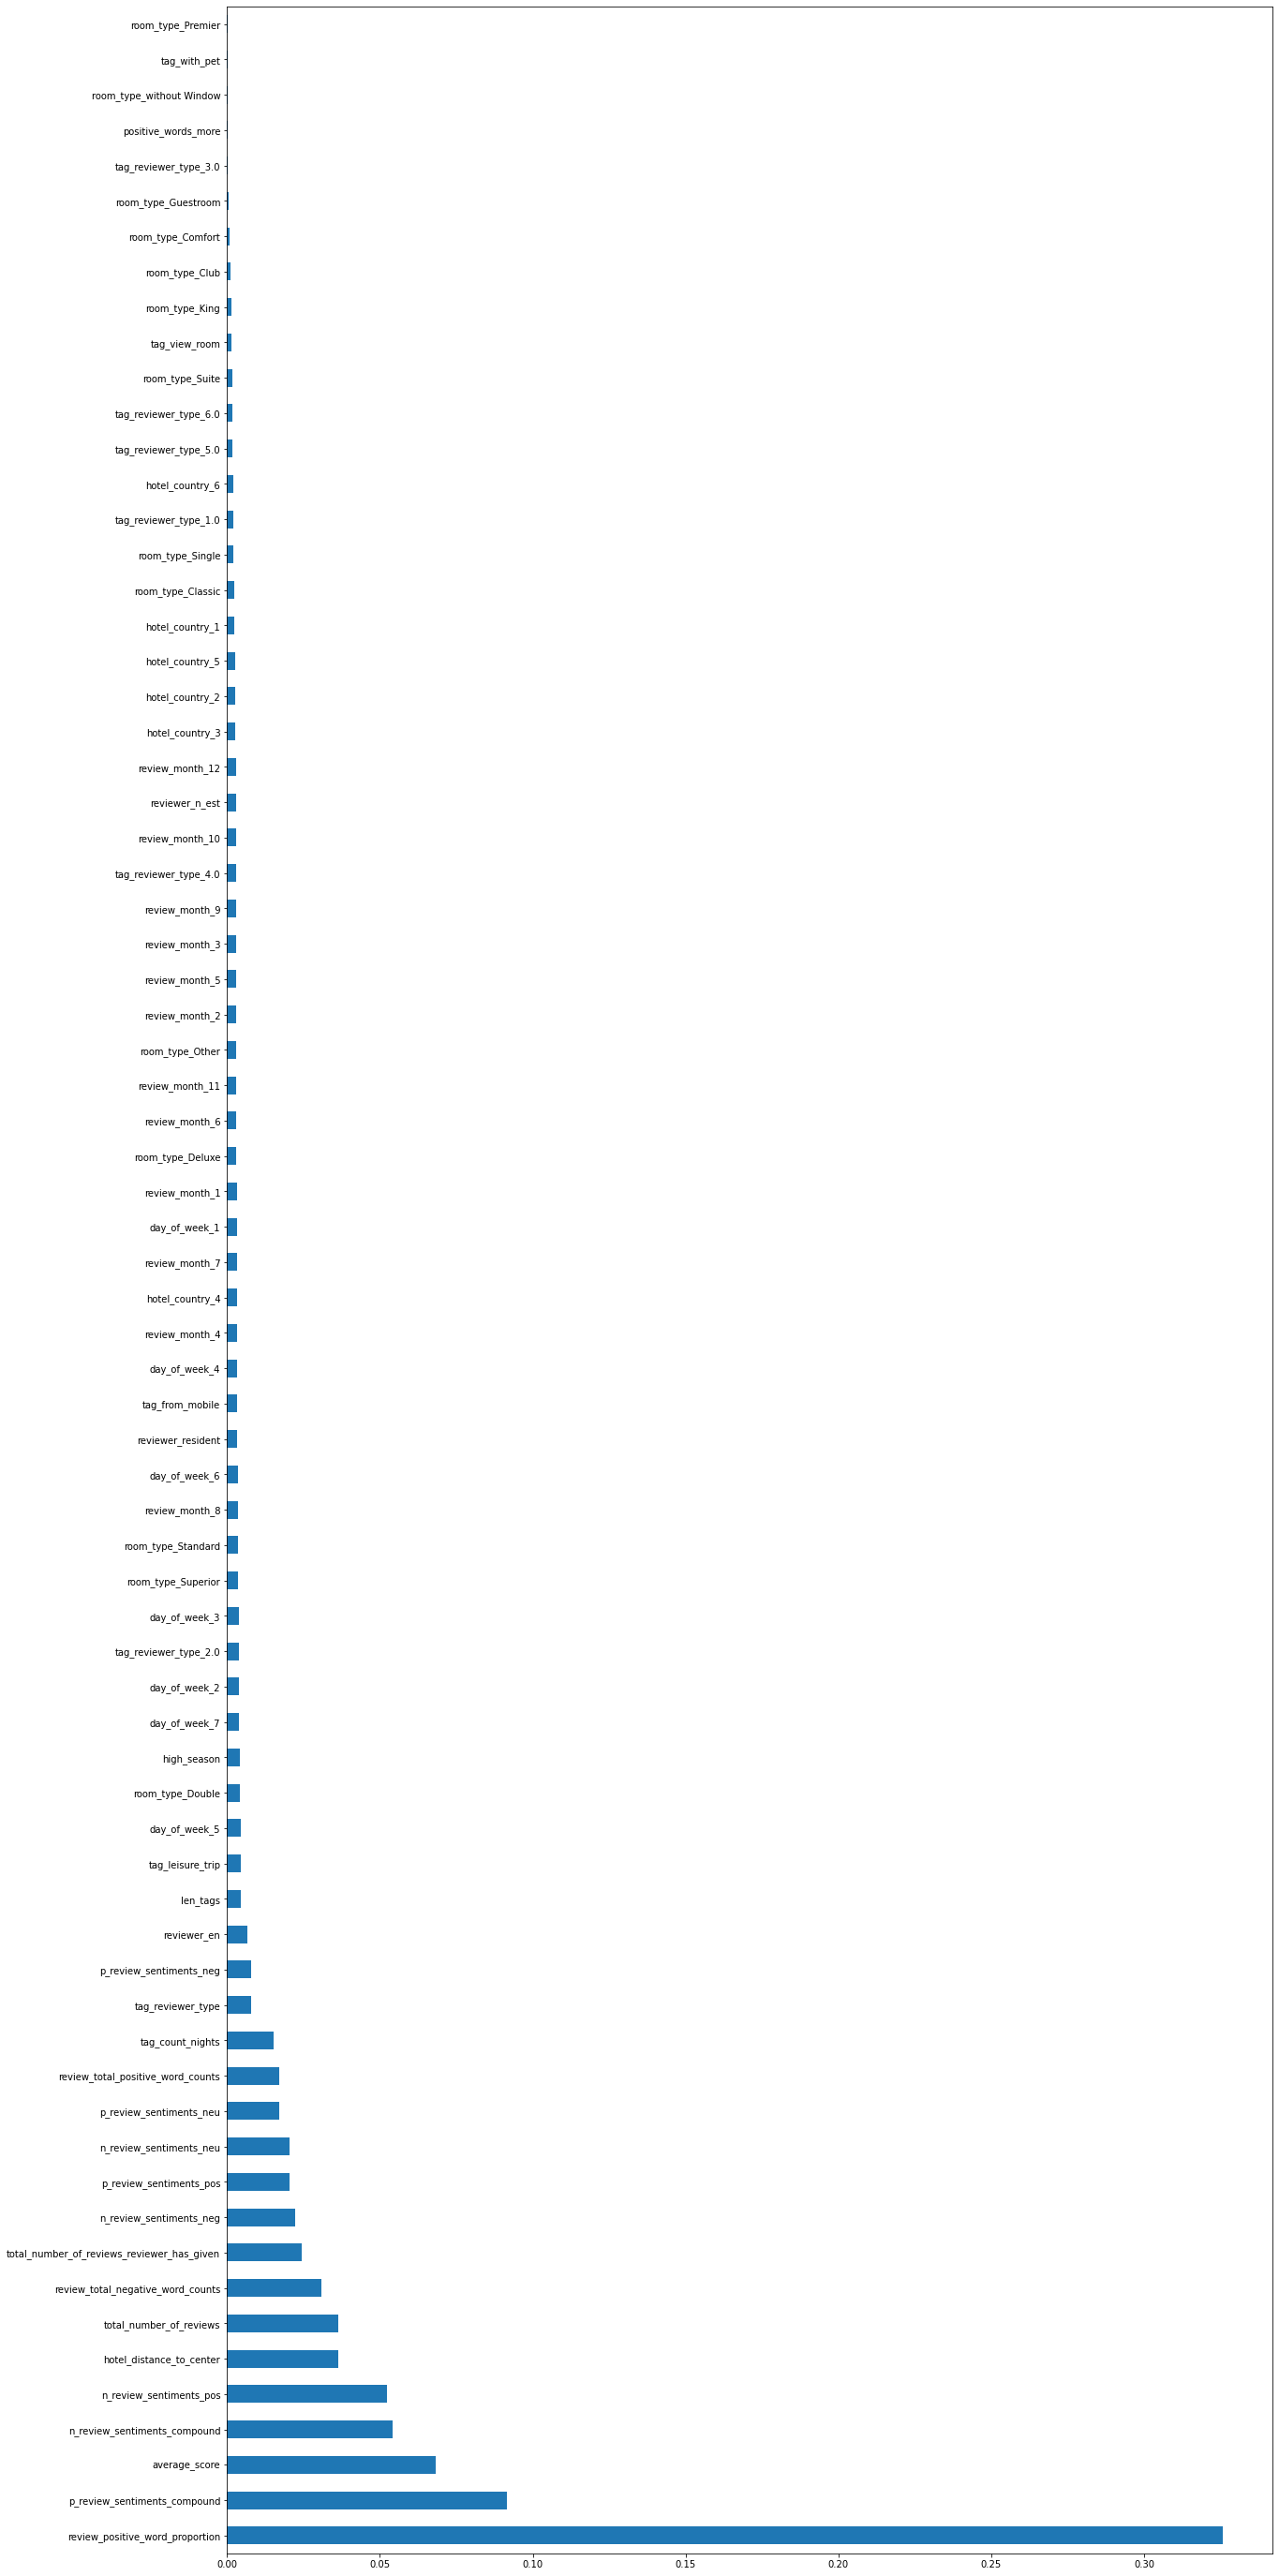

In [148]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,50)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(feat_importances)).plot(kind='barh')


In [149]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,...,room_type_Comfort,room_type_Guestroom,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
109382,8.600,6,1572,4,0.693,0.000,0,0,0,1,...,0,0,0.420,0.580,0.000,-0.440,0.000,1.000,0.000,0.000
84053,8.700,0,8177,7,0.693,0.000,0,1,0,0,...,0,0,0.000,0.000,1.000,0.557,0.000,0.221,0.779,0.890
49278,8.300,15,1806,24,1.792,0.000,1,0,0,0,...,0,0,0.141,0.705,0.154,0.052,0.000,0.699,0.301,0.848
46148,8.500,5,904,3,1.099,0.000,1,0,0,0,...,0,0,0.534,0.466,0.000,-0.317,0.000,1.000,0.000,0.000
8204,9.100,8,975,10,0.693,0.000,0,0,0,1,...,0,0,0.000,0.727,0.273,0.309,0.000,0.678,0.322,0.586
25281,7.900,19,183,18,2.303,0.000,0,0,0,0,...,0,0,0.144,0.856,0.000,-0.402,0.000,0.456,0.544,0.936
70520,7.400,16,5575,4,2.079,0.000,0,0,0,0,...,0,0,0.000,0.818,0.182,0.440,0.000,1.000,0.000,0.000
90130,8.900,0,2836,13,0.693,0.000,0,0,0,1,...,0,0,0.000,0.000,1.000,0.557,0.000,1.000,0.000,0.000
72877,8.400,37,3222,27,2.079,0.000,0,0,1,0,...,0,0,0.094,0.906,0.000,-0.477,0.000,0.467,0.533,0.966
8981,9.100,0,501,28,2.890,0.000,0,0,0,1,...,0,0,0.000,0.000,1.000,0.557,0.089,0.594,0.317,0.769


In [150]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [151]:
sample_submission

,reviewer_score,id
0,8.562,488440
1,7.434,274649
2,8.031,374688
3,9.584,404352
4,9.509,451596
...,...,...
128930,9.057,495812
128931,8.874,315577
128932,7.757,511968
128933,9.628,303386


In [152]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


In [153]:
predict_submission

array([8.513, 7.164, 8.075, ..., 8.368, 9.568, 7.631])

In [154]:
list(sample_submission)

['reviewer_score', 'id']

In [155]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv_V_23', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.513,488440
1,7.164,274649
2,8.075,374688
3,9.855,404352
4,9.478,451596
5,8.940,302161
6,7.483,317079
7,7.596,13963
8,8.543,159785
9,7.854,195089
